# <a name="0">AWEsome Workshop - Identifying and Mitigating Bias in ML</a>

__ML Problem:__ 
The example ML problem for this workshop is a so called binary classification (predicting whether something or someone belongs to a class or not). In this case, we aim to predict whether someone is going to receive a government grant or not. This is a hypothetical prediction problem with an underlying true story:

Whether or not someone will receive a grant depends on personal circumstances and all individuals are different. It can be argued that when a human decision maker is approving or denying grants, they can be influenced. This is especially bad if there is a limited resource (e.g. grants) the government can hand out; grants should not be disproportionately awarded to a certain group. Therefore, a machine learning solution is desirable as this can be considered objective decision making. As we will see, this is not necessarily the case. Machine Learning models depend on the input data they use to learn from and said inputs can be inherently biased. 

The dataset used in this example us using US census information on individuals and was generated using [folktables](https://github.com/zykls/folktables). Folktables provide code to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau.

__Notebook Structure:__ 
In this workshop we will build a classifier to predict if an individual is awarded a government grant or not. The structure of the notebook is outlined below:

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Measuring Bias</a>
    * <a href="#23">Train - Validation - Test Datasets</a>
3. <a href="#3">Training a Classifier</a>
    * <a href="#31">Reweighing</a>
    * <a href="#32">Model Training</a>
    * <a href="#33">Making Predictions w/o Bias Mitigation</a>
4. <a href="#4">Measuring Prediction Bias</a>

Before we can started with the notebook, we need to load certain libraries. If you have never worked with a Jupyter Notebook before, [this video](https://youtu.be/R1qVqAZfPes?t=85) can be a helpful introduction.

In [1]:
# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

# Operational libraries
import sys

sys.path.append("..")

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's import data using [Pandas ` .read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) method.

In [2]:
df = pd.read_csv("census_sample.csv")

## 2. <a name="2">Data Processing and Exploration</a>
(<a href="#0">Go to top</a>)

Before building a Machine Learning (ML) model, it is very important to analyse the data and check for bias. There are many different ways in which bias can hide in a dataset; for this workshop, we will only look at bias that can arise through sampling issues or historical discrepancies between racial groups in the United States.

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [3]:
# Check how many rows and columns we have in the data frame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (1000, 11)


Let's look at the data set itself and print the first five rows.


In [4]:
df.head()

,AGEP,COW,SCHL,MAR,RELP,WKHP,SEX,RAC,PWGTP,SCH,awarded_grant
0,30.0,1.0,21.0,5.0,0.0,50.0,2.0,A,169.0,1.0,1
1,19.0,1.0,16.0,5.0,2.0,40.0,1.0,B,102.0,1.0,0
2,29.0,1.0,20.0,5.0,2.0,40.0,2.0,A,170.0,1.0,0
3,33.0,6.0,16.0,5.0,2.0,20.0,1.0,A,237.0,1.0,0
4,46.0,7.0,16.0,3.0,0.0,30.0,1.0,A,81.0,1.0,1


In [5]:
# We distinguish between categorical and numerical features
categorical_features = ["COW", "SCHL", "MAR", "RELP", "SEX", "SCH"]
numerical_features = ["AGEP", "WKHP", "PWGTP"]
sensitive_features = ["RAC"] # this is an example; depending on context age, gender, ... can be sensitive

# We cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# We cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

One thing we might notice here are the unintuitive feature names; with a few exceptions it is very difficult to understand what the features refer to; e.g. MAR could refer to March. In this context, the data owners are actually encoding the marital status. It could be worthwhile to rename the features, so it will be easier later to understand what they actually refer to. This can be done by creating a renaming dictionary and by using the [Pandas `.rename()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) method.

```
# Create dictionary for new column names
rename_dict = {"MAR":"marital_status"} 

# Apply new names to dataframe
df.rename(rename_dict, axis=1, inplace=True)

```

For now, we will proceed without the renaming, and simply list the mapping between feature name and proceed to separate the model target from the features that we want to use to predict the target.

In [6]:
# We distinguish between features and target (what we want to predict)
model_target = "awarded_grant"
model_features = categorical_features + numerical_features

Before we start measuring bias, we can look at the data frame again and color the columns based on their type.

In [7]:
# Apply styling to the data frame columns to visually see which column is which data type

df.head().style.set_precision(0).set_properties(
    **{"background-color": "#eaddde"}, subset=categorical_features
).set_properties(
    **{"background-color": "#c2ebbb"}, subset=numerical_features
).set_properties(
    **{"background-color": "#dae0e9"}, subset=sensitive_features
)

/var/folders/bp/n39rnln17tzd7f12lnw6br7w0000gr/T/ipykernel_14008/1188350711.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.head().style.set_precision(0).set_properties(


,AGEP,COW,SCHL,MAR,RELP,WKHP,SEX,RAC,PWGTP,SCH,awarded_grant
0,30,1,21,5,0,50,2,A,169,1,1
1,19,1,16,5,2,40,1,B,102,1,0
2,29,1,20,5,2,40,2,A,170,1,0
3,33,6,16,5,2,20,1,A,237,1,0
4,46,7,16,3,0,30,1,A,81,1,1


### 2.2 <a name="21">Measuring Bias</a>
(<a href="#2">Go to Data Processing</a>)

Let's check our target distribution to see if we have biased labels. First, we can look at the labels without overlay of the group membership.

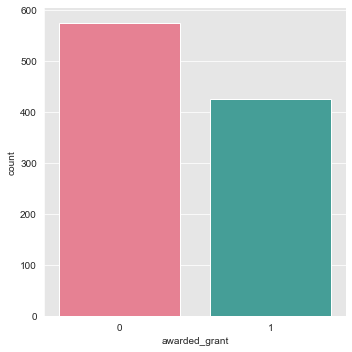

In [8]:
sns.catplot(
    x=model_target,
    data=df,
    hue_order=[1, 0],
    kind="count",
    palette=sns.husl_palette(2),
)
plt.show()

We notice that we are dealing with an imbalanced dataset. This means there are more examples for one type of results (here: 0; meaning individuals not awarded grants). The question now: Will the target distribution be similar per group or is there one group in the data set that has more individuals awarded grants than not. We start with a plot:

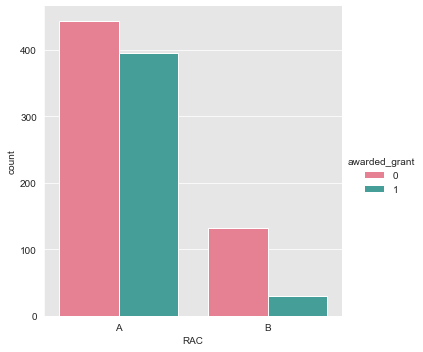

In [9]:
sns.catplot(
    x="RAC",
    kind="count",
    hue=model_target,
    hue_order=[0, 1],
    data=df,
    palette=sns.husl_palette(2),
)
plt.show()

It appears that the ratio of outcomes vastly differs per group (i.e. Group B has a much worse ratio of individuals awarded grants vs. not). To analyse this in more detail, we need to separate out the groups and calculate the **Difference in Proportion of Labels**. We might also want to know how the *sizes* of the groups compare overall; for this, we calculate **Normalized Class Imbalance**.

#### Normalized Class Imbalance (CI)
To calculate class imbalance, we compare the number of individuals per group by subtracting. To normalize, we divide by the total number of individuals in the data set. The equation for Normalized Class Imbalance is therefore:
<br>
<br>


<center>$CI = \frac{n_{RAC=A} - n_{RAC=B}}{n_{RAC=A} + n_{RAC=B}}$</center>

In [10]:
n_A = len(df[df["RAC"] == "A"])  # n_RAC="A"
n_B = len(df[df["RAC"] == "B"])  # n_RAC="B"

In [13]:
# Implement the equation for CI
# Use the variables n_A and n_B to complete the equation

ci = (n_A-n_B)/(n_A+n_B)

print(ci)

0.676


#### Difference in Proportion of Labels (DPL)
The difference in proportions of labels (DPL) compares the proportion of the labels with positive outcome for Group A with the proportion of labels with positive outcome of Group B. One important thing to note: It is always important to think about the meaning of the label and relate it to what can be considered "positive" in a given context.
<br>
<br>

<center>$DPL = \frac{n_{eligible \wedge RAC=A}}{n_{RAC=A}} - \frac{n_{eligible \wedge RAC=B}}{n_{RAC=B}}$</center>

In [14]:
n_eligible_A = len(df[(df["RAC"] == "A") & (df[model_target] == 1)])
n_eligible_B = len(df[(df["RAC"] == "B") & (df[model_target] == 1)])

In [15]:
# Implement the equation for DPL
# Use the variables defined above to complete the equation

dpl = (n_eligible_A/n_A)-(n_eligible_B/n_B)

print(dpl)

0.28617519667639


Which group is disproportionately favored? You can have a look at the [definition of DPL](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-true-label-imbalance.html) or the slides for help. 

```


```

The DPL values range over the interval [-1, 1]. If DPL is close enough to 0, then we say that demographic parity has been achieved. The closer to 0 the better.

### 2.3 <a name="23">Train - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

A standard step when building Machine Learning models is to split the data into several separate data frames (some of which will be used to train/learn a model and others to evaluate it). For more details about the this step, have a look at an interactive article [here](https://mlu.corp.amazon.com/explain/train-test-validation). In this notebook, we will use [Sklearn's `train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method to split the data.

Don't worry about fully understanding this; we are including the code as it is standard practice in Machine Learning.

In [16]:
# We split the dataframe (df) into a train (90%) and test (20%) set
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=1
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test datasets shapes: ",
    train_data.shape,
    test_data.shape,
)

Train - Test datasets shapes:  (900, 11) (100, 11)


## 3. <a name="3">Training a Classifier</a>
(<a href="#0">Go to top</a>)

We are ready to build a model. In this workshop we will implement a KNN classifier. To show the difference bias mitigation has on the result, we will train the KNN classifier in two different ways:
1. KNN without bias mitigation 
2. KNN with bias mitigation (reweighing)

To implement the bias mitigation, we first need to calculate the reweighing factors that we can then pass into the KNN algorithm.

### 3.1 <a name="31"> Reweighing</a>
(<a href="#3">Go to Train a Classifier</a>)

Below you can find the code implementation that will calculate the weights per group.

In [17]:
def reweighing(data, label, sensitive_attr, return_list=True):
    label_dict = dict()
    try:
        # This will loop through the different labels (1 - awarded grant, 0 - not awarded)
        for outcome in data[label].unique():
            weight_map = dict()
            # Check for all possible groups (here we have A & B but there could be more in reality)
            for val in data[sensitive_attr].unique():
                # Calculate the probabilities
                nom = (
                    len(data[data[sensitive_attr] == val])
                    / len(data)
                    * len(data[data[label] == outcome])
                    / len(data)
                )
                denom = len(
                    data[(data[sensitive_attr] == val) & (data[label] == outcome)]
                ) / len(data)
                # Store weights according to sensitive attribute
                weight_map[val] = round(nom / denom, 2)
            # Store 
            label_dict[outcome] = weight_map
        # Create full list of all weights for every data point provided as input
        data["weights"] = list(
            map(lambda x, y: label_dict[y][x], data[sensitive_attr], data[label])
        )
        if return_list == True:
            return data["weights"].to_list()
        else:
            return label_dict
    except Exception as err:
        print(err)
        print("Dataframe might have no entries.")

The output of the `reweighing` function is a nested dictionary where the outer keys of the dictionary indicate the outcomes (eligible or not). The inner keys in the dictionary correspond to the sensitive groups and the values are the weights.

In [18]:
# 2 outcomes (eligible or not eligible for medicare) and 2 groups (Group A & Group B) yield 4 weighting factors
print(reweighing(df, model_target, "RAC", return_list=False))

# df: this is our data frame
# model_target: this is "awarded_grant"

{1: {'A': 0.9, 'B': 2.3}, 0: {'A': 1.09, 'B': 0.71}}


We want to calculate the weights for every row of our data frame and store those in a list:

In [19]:
# We store all the weights in a list
bias_weights = reweighing(df, model_target, "RAC", return_list=True)

### 3.2 <a name="32">Model Training</a>
(<a href="#3">Go to Train a Classifier</a>)

We want to use K-Nearest Neighbor classifier for predictions in this workshop. The KNN algorithm follows these steps:
1. Calculate distance between the data point that we want to predict for and all data points from the training set
2. Sort the distance values from closest to furthest and select k closest (neighbors)
3. Check which class the k closest neighbors belong to and assign majority vote as prediction output

This algorithm is implemented efficiently in Sklearn. However, the default algorithm does not allow directly for bias mitigation, so we will use a custom KNN implementation. Before we can use KNN, we need to clean up our data frame a little bit and scale all values. Otherwise KNN will simply favor certain predictions based on the scale the feature has.

In [20]:
# Let's prepare the training data
X_train = train_data[model_features]
y_train = train_data[model_target]

# Scale the training data to avoid feature scale impacting the results
X_train = pd.concat(
    [
        (X_train[numerical_features] - X_train[numerical_features].min())
        / (X_train[numerical_features].max() - X_train[numerical_features].min()),
        pd.get_dummies(X_train.drop(numerical_features, axis=1)),
    ],
    axis=1,
)

In [21]:
def KNN_Classifier(test_df, n_neighbors=3, weighted=True):
    """Custom KNN Classifier with bias weight scaling."""
    # Create empty list to store predictions in
    predictions = []
    # For every point in the test data, calculate distance to train data
    for k in range(len(test_df)):
        dis = []
        for i in range(len(X_train)):
            dis.append(
                euclidean_distances(
                    test_df.iloc[k].values.reshape(1, -1),
                    X_train.iloc[i].values.reshape(1, -1),
                )[0][0]
            )
        # Divide by bias weights to scale data
        if weighted == True:
            dis_new = [i / j for i, j in zip(dis, bias_weights)]
        else:
            dis_new = dis
        # Find k closest neighbors
        neighbors = np.array(dis_new).argsort()[:n_neighbors]
        # Select the classes those neighbors have
        neighbors_classes = y_train.iloc[neighbors].to_list()
        # Create majority vote
        majority_vote = max(set(neighbors_classes), key=neighbors_classes.count)
        # Store vote as prediction output
        predictions.append(majority_vote)
    return predictions

### 3.3 <a name="33">Making Predictions w/o Bias Mitigation</a>
(<a href="#3">Go to Train a Classifier</a>)

Before we can make predictions, we need to make sure that data we want to test on is also scaled.

In [22]:
# Get validation data to validate the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Scale the test data to avoid feature scale impacting the results
X_test = pd.concat(
    [
        (X_test[numerical_features] - X_test[numerical_features].min())
        / (X_test[numerical_features].max() - X_test[numerical_features].min()),
        pd.get_dummies(X_test.drop(numerical_features, axis=1)),
    ],
    axis=1,
)

# Finally, we need to make sure that all columns that exist in X_train also exist in X_test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

The goal for the model is to create predictions for both groups that have a DPL value as close to 0 as possible. Therefore, we will train the model with and then without bias mitigation (reweighing) and compare the DPL values.

In [23]:
test_predictions = KNN_Classifier(X_test, n_neighbors=5, weighted=False)

In the cell below, call the `KNN_Classifier` function and set the weight parameter to `True`. Keep the number of neighbors at 5 to make it a fair comparison.

In [24]:
# Complete the code here
test_predictions_mitigation = KNN_Classifier(X_test, n_neighbors=5, weighted=True)

We will create a new data frame with all the predictions to make it easier to compare:

In [25]:
# Create dataframe that contains predictions and the sensitive attribute
pred_df = pd.concat(
    [
        test_data.reset_index(drop=True)[["RAC", model_target]],
        pd.Series(test_predictions, name="y_test_pred"),
        pd.Series(test_predictions_mitigation, name="y_test_mitigation"),
    ],
    axis=1,
)

pred_df.head()

,RAC,awarded_grant,y_test_pred,y_test_mitigation
0,A,0,1,0
1,A,0,1,0
2,A,1,1,0
3,B,0,1,0
4,A,0,0,0


## 4. <a name="4">Measuring Prediction Bias: DPL for Predictions (DPPL)</a> 

Now that we have predictions we can compare and check several things:
- Check what the baseline DPL value is for the test data 
- Compare how the model with mitigation fares again the baseline
- Compare how the model without intervention fares again the baseline

#### DPL baseline
Let's start by calculating the baseline DPL value.


In [26]:
n_A_post = len(pred_df[pred_df["RAC"] == "A"])  # n_RAC=A
n_B_post = len(pred_df[pred_df["RAC"] == "B"])  # n_RAC=B

In [27]:
n_eligible_A_test = len(
    pred_df[(pred_df["RAC"] == "A") & (pred_df[model_target] == 1)]
)
n_eligible_B_test = len(
    pred_df[(pred_df["RAC"] == "B") & (pred_df[model_target] == 1)]
)

((n_eligible_A_test) / (n_A_post)) - ((n_eligible_B_test) / (n_B_post))

0.2651072124756335

The baseline is pretty much exactly what we saw when calculating DPL across the whole data set (the above is DPL for the test proportion). We can be sure that our test data follows the same distribution as the full data set and proceed to compare the model predictions to the baseline we just established.

#### DPL for Model with no intervention
Let's calculate DPL for the predictions and compare them to the original DPL value (the difference in proportion of labels in the original data frame):

In [28]:
n_eligible_A_post = len(
    pred_df[(pred_df["RAC"] == "A") & (pred_df["y_test_pred"] == 1)]
)
n_eligible_B_post = len(
    pred_df[(pred_df["RAC"] == "B") & (pred_df["y_test_pred"] == 1)]
)

# Calculate DPPL for the model with no bias mitmigation
((n_eligible_A_post) / (n_A_post)) - ((n_eligible_B_post) / (n_B_post))

0.28654970760233917

We can see here that the model without bias intervention actually made the situation worse for Group B. Before the model was trained, the DPL value was 0.27; the predictions give a DPL of 0.29. So without any intervention, this model is predicting slightly more biased results vs. the baseline. This is a very small difference and could be due to fluctuation but could also indicate a pattern.


#### DPL for Model with bias mitigation
Let's have a look at the DPL value for the model that was trained with the bias weights:

In [29]:
n_eligible_A_mitigated_post = len(
    pred_df[(pred_df["RAC"] == "A") & (pred_df["y_test_mitigation"] == 1)]
)
n_eligible_B_mitigated_post = len(
    pred_df[(pred_df["RAC"] == "B") & (pred_df["y_test_mitigation"] == 1)]
)

# Calculate DPPL for the model with bias mitigation
((n_eligible_A_mitigated_post) / (n_A_post)) - (
    (n_eligible_B_mitigated_post) / (n_B_post)
)

0.11630929174788823

This value looks much better. Clearly the reweighing took effect. While comparing the DPL values is very helpful, it is also advisable to plot the distribution of predictions to visually inspect the behavior.

We create three plots below:
1. Baseline
2. Biased Model
3. Mitigation

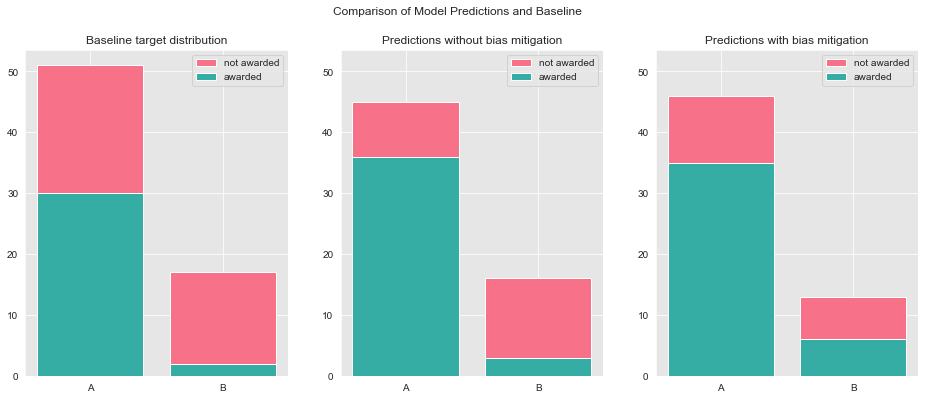

In [30]:
# Initialize figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
# Set title of figure
fig.suptitle("Comparison of Model Predictions and Baseline")

# Create first plot of baseline values
ax1.bar(
    ["A", "B"],
    pred_df[pred_df[model_target] == 0]["RAC"].value_counts(),
    color="#f77189",
)
ax1.bar(
    ["A", "B"],
    pred_df[pred_df[model_target] == 1]["RAC"].value_counts(),
    color="#36ada4",
)

ax1.legend(["not awarded", "awarded"])
ax1.title.set_text('Baseline target distribution')

# Create second plot of values without bias mitigation
ax2.bar(
    ["A", "B"],
    pred_df[pred_df["y_test_pred"] == 0]["RAC"].value_counts(),
    color="#f77189",
)
ax2.bar(
    ["A", "B"],
    pred_df[pred_df["y_test_pred"] == 1]["RAC"].value_counts(),
    color="#36ada4",
)

ax2.legend(["not awarded", "awarded"])
ax2.title.set_text('Predictions without bias mitigation')

# Create third plot of values with bias mitigation
ax3.bar(
    ["A", "B"],
    pred_df[pred_df["y_test_mitigation"] == 0]["RAC"].value_counts(),
    color="#f77189",
)
ax3.bar(
    ["A", "B"],
    pred_df[pred_df["y_test_mitigation"] == 1]["RAC"].value_counts(),
    color="#36ada4",
)

ax3.legend(["not awarded", "awarded"])
ax3.title.set_text('Predictions with bias mitigation')

# Align y-axis
ax2.sharey(ax1)
ax3.sharey(ax1)

This is looking very promising indeed. We can clearly see that the model with bias mitigation has a much more balanced output across the groups A and B. There is one obvious issue with this - the model here assumes that our fictional government has grants to give to everyone who is deserving. In reality, this does not always hold true and we might need to look at another fairness metric that balances the outcomes while also restricting the total number of positives.

## Thank you for participating in the workshop!

If you finished this notebook quickly and want another challenge, try and implement another classification algorithm: Logistic Regression (don't get fooled by the name, this really is a classifier).

The syntax for Logistic Regression is:

```
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(solver="liblinear", penalty="l2")
```

It is possible pass the bias_weights to the Logistic Regression algorithm in the [`.fit()` method](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit) by specifying `sample_weight = list(map(bias_weights.__getitem__, X_train.index))`. This will select the correct bias weights based on the index of the training data points.

In [ ]:
# Implement the code here - this is purely optional in case you are done quickly 

In [31]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(solver="liblinear", penalty="l2")

In [32]:
sample_weight = list(map(bias_weights.__getitem__, X_train.index))

In [35]:
# Complete the code here
test_predictions_mitigation = KNN_Classifier(X_test, n_neighbors=5, weighted=True)

TypeError: 'LogisticRegression' object is not callable